In [13]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentencepiece
!pip install optuna

import os
# import re
# import string
import codecs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from bs4 import BeautifulSoup

# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, classification_report, precision_recall_curve
from sklearn.naive_bayes import MultinomialNB  # ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA, TruncatedSVD, SparsePCA, LatentDirichletAllocation
from sklearn.model_selection import KFold

from lightgbm import LGBMClassifier

import sentencepiece as spm
import optuna

     |████████████████████████████████| 1.2 MB 5.2 MB/s 
     |████████████████████████████████| 302 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 208 kB 42.6 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 111 kB 64.8 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 141 kB 47.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=079a2766810c6d37014c9bac742721f81cd40d23ef4807babdec0254f3b06199
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def seed_everything(seed=42):
  # random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  # tf.random.set_seed(seed)
  # torch.manual_seed(seed)
  # torch.cuda.manual_seed(seed)
  # torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

In [ ]:
DRIVE_PATH = '/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ'

In [ ]:
DATA_DIR = os.path.join(DRIVE_PATH, "input")

In [ ]:
# read csv ---------------------------------------------------------------------
original_train_df = pd.read_csv(os.path.join(DATA_DIR, "train_clean_df.csv"))
original_test_df = pd.read_csv(os.path.join(DATA_DIR, "test_clean_df.csv"))
train_df = original_train_df.copy()
test_df = original_test_df.copy()

train_df['clean_abstract'].replace('','missing',inplace=True)
test_df['clean_abstract'].replace('','missing',inplace=True)

# length -----------------------------------------------------------------------
train_length = len(original_train_df)
test_length = len(original_test_df)

In [ ]:
class SpamMail:

  def __init__(self):
    pass

In [ ]:
class Preprocessor:
  def __init__(self):
    pass

  def __remove_head(self, X):
    """ 先頭の'Subject: 'を削除する """
    X_series = pd.Series(X)
    if X_series.str.startswith("Subject: ").all():
      X_series = X_series.apply(lambda c: c[9:])
    X = X_series.values
    return X

  # def __denoise_text(self, X):
  #   X = self.__remove_head(X)
  #   return X

  def preprocess(self, X):
    X = X.copy()
    X = self.__remove_head(X)
    return X

In [ ]:
class SentencePieceTokenizer:
  def __init__(
      self,
      model_prefix,
      vocab_size = 5000,
      user_defined_symbols = ("(",")","\"","-",".","–","£","€"),
      shuffle_input_sentence = True,
      character_coverage = 1.0,
      model_type = "unigram"):
    self.processor = spm.SentencePieceProcessor()
    self.model_prefix = model_prefix
    self.vocab_size = vocab_size
    self.user_defined_symbols = user_defined_symbols
    self.shuffle_input_sentence = shuffle_input_sentence
    self.character_coverage = character_coverage
    self.model_type = model_type

  def __call__(self, raw_document):
    return self.tokenize(raw_document)
  
  def tokenize(self, raw_document):
    # raw_document: 1文の文字列  例: "こんにちは、世界"
    return self.processor.EncodeAsPieces(raw_document)

  def fit(self, X):
    document_file = f"{self.model_prefix}.txt"
    # すべての文字列をテキストファイルに書き出す
    print(*X, sep="\n", file=codecs.open(document_file, "w", "utf-8"))
    spm.SentencePieceTrainer.Train(
        input = document_file,
        model_prefix = self.model_prefix,
        vocab_size = self.vocab_size,
        user_defined_symbols = self.user_defined_symbols,
        shuffle_input_sentence = self.shuffle_input_sentence,
        character_coverage = self.character_coverage,
        model_type = self.model_type
    )
    model_name = f"{self.model_prefix}.model"
    self.processor.Load(model_name)

In [ ]:
is_not_spam = train_df["judgement"] == 0
is_spam = train_df["judgement"] == 1

is_not_spam_index = np.where(is_not_spam)[0]
is_spam_index = np.where(is_spam)[0]

In [ ]:
X = pd.DataFrame(train_df['clean_abstract'])
y = pd.DataFrame(train_df['judgement'])

In [ ]:

# Class Dictionary -------------------------------------------------------------
tokenizer_cls_dict = {
    "SentencePieceTokenizer": SentencePieceTokenizer
}
vectorizer_cls_dict = {
    "CountVectorizer": CountVectorizer,
    "TfidfVectorizer": TfidfVectorizer
}
decomposition_cls_dict = {
    "NMF": NMF, "PCA": PCA, "SparsePCA": SparsePCA, "TruncatedSVD": TruncatedSVD,
    "LatentDirichletAllocation": LatentDirichletAllocation
}
model_cls_dict = {
    "MultinomialNB": MultinomialNB,
    "LGBMClassifier": LGBMClassifier
}

In [ ]:
# Parameter --------------------------------------------------------------------
n_splits = 20

# tokenizer 
tokenizer_name = "SentencePieceTokenizer"
tokenizer_params = {
    "model_prefix": "train",
    "vocab_size": 5000,  # 5000,
    "user_defined_symbols": ["(",")","\"","-",".","–","£","€"],
    "shuffle_input_sentence": True,
    "character_coverage": 1.0,
    "model_type": "unigram"}

# vectorizer
vectorizer_name = "CountVectorizer"
vectorizer_params = {
    "min_df": 1,  # 2
    "max_df": 1.0,  # 0.7
    "ngram_range": (1, 1),  # (1, 1),
    "stop_words": ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on'], #None,
    "token_pattern": None}

# model
model_name = "MultinomialNB"
#model_name = "LGBMClassifier"
model_params = {}
model_fit_params = {}

In [ ]:
# Main Part --------------------------------------------------------------------

val_preds = np.zeros(train_length)
preds = []
preprocessor = Preprocessor()
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

for (train_index_spam, val_index_spam), (train_index_not_spam, val_index_not_spam) in zip(kfold.split(is_spam_index), kfold.split(is_not_spam_index)):
  # print(train_index_spam.shape, val_index_spam.shape, train_index_not_spam.shape, val_index_not_spam.shape)
  # print(train_index_spam, val_index_spam, train_index_not_spam, val_index_not_spam)

  # downsampling ---------------------------------------------------------------
  n_train_spam = len(train_index_spam)
  train_index_not_spam = np.random.choice(train_index_not_spam, n_train_spam, replace=False)
  n_val_spam = len(val_index_spam)
  val_index_not_spam_downsampled = np.random.choice(val_index_not_spam, n_val_spam, replace=False)

  train_index = np.concatenate((is_spam_index[train_index_spam], is_not_spam_index[train_index_not_spam]), axis=0)
  val_index = np.concatenate((is_spam_index[val_index_spam], is_not_spam_index[val_index_not_spam]), axis=0)
  val_index_downsampled = np.concatenate((is_spam_index[val_index_spam], is_not_spam_index[val_index_not_spam_downsampled]), axis=0)

  X_resampled = X.loc[train_index, "clean_abstract"].values
  y_resampled = y.loc[train_index, "judgement"].values
  X_val = X.loc[val_index, "clean_abstract"].values
  y_val = y.loc[val_index, "judgement"].values
  X_val_downsampled = X.loc[val_index_downsampled, "clean_abstract"].values
  y_val_downsampled = y.loc[val_index_downsampled, "judgement"].values

  # preprocess -----------------------------------------------------------------
  X_resampled = preprocessor.preprocess(X_resampled)
  X_val = preprocessor.preprocess(X_val)
  X_val_downsampled = preprocessor.preprocess(X_val_downsampled)

  # tokenizer ------------------------------------------------------------------
  tokenizer = tokenizer_cls_dict[tokenizer_name](**tokenizer_params)
  tokenizer.fit(X_resampled)

  # vectorizer -----------------------------------------------------------------
  vectorizer = vectorizer_cls_dict[vectorizer_name](tokenizer=tokenizer, **vectorizer_params)
  vectorizer.fit_transform(X_resampled.astype('U')) 
  

  # 単語の出現回数取得 ---------------------------------------------------------
  # 単語の種類の表示
  print('word size: ', len(vectorizer.vocabulary_))
  # 先頭５件の単語を表示
  print('word content: ', dict(list(vectorizer.vocabulary_.items())[0:5]))

  # 訓練データと検証データをベクトル化 -----------------------------------------
  X_resampled_vec = vectorizer.transform(X_resampled.astype('U'))
  X_val_vec = vectorizer.transform(X_val.astype('U'))
  X_val_vec_downsampled = vectorizer.transform(X_val_downsampled.astype('U'))

  # 学習 -----------------------------------------------------------------------
  model = model_cls_dict[model_name](**model_params)
  model.fit(X_resampled_vec, y_resampled, **model_fit_params)

  # validation data の予測 -----------------------------------------------------
  val_pred = model.predict_proba(X_val_vec)[:, 1]
  val_preds[val_index] = val_pred
  val_pred_downsampled = model.predict_proba(X_val_vec_downsampled)[:, 1]

  # F1スコアのprint
  print("val_fbeta-score",fbeta_score(y_val, np.where(val_pred>0.5, 1, 0),beta=7))
  print("downsampled_val_fbeta-score",fbeta_score(y_val_downsampled, np.where(val_pred_downsampled>0.5, 1, 0),beta=7))
  print("------------------------------------------------------------------------------------------------------------------")

  # testデータをベクトル化
  # df_data = pd.DataFrame(test, columns=['contents'])
  input_vec = vectorizer.transform(preprocessor.preprocess(test_df['clean_abstract'].values.astype('U')))

  # testの予測→seed毎に空のリストに格納
  pred = model.predict_proba(input_vec)
  preds.append(pred)
# end for ----------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'm', 's', '▁', '▁a', '▁an', '▁ar', '▁fro', '▁i', '▁if', '▁in', '▁it', '▁on', '▁or', '▁th', '▁thi', '▁to'] not in stop_words.



word size:  4965
word content:  {'▁background': 1606, '▁severe': 4299, '▁acute': 1363, '▁respirator': 4131, 'y': 1270}
val_fbeta-score 0.8106694560669456
downsampled_val_fbeta-score 0.9639303482587064
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ar', 'at', 'd', 'e', 'm', 'o', 'r', 's', '▁', '▁a', '▁am', '▁an', '▁f', '▁i', '▁if', '▁in', '▁it', '▁of', '▁or', '▁th', '▁to'] not in stop_words.



word size:  4962
word content:  {'▁back': 1570, 'g': 430, 'round': 973, '▁severe': 4335, '▁acute': 1314}
val_fbeta-score 0.8002065049044914
downsampled_val_fbeta-score 0.9627329192546582
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'f', 'om', 'r', 's', '▁', '▁a', '▁am', '▁an', '▁ar', '▁f', '▁i', '▁in', '▁it', '▁of', '▁or', '▁th', '▁the', '▁to'] not in stop_words.



word size:  4960
word content:  {'▁background': 1589, '▁severe': 4308, '▁acute': 1330, '▁respi': 4151, 'rator': 941}
val_fbeta-score 0.7735946364105208
downsampled_val_fbeta-score 0.9316770186335405
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'e', 'f', 'm', 'ro', 's', '▁', '▁a', '▁am', '▁an', '▁ar', '▁f', '▁i', '▁in', '▁it', '▁of', '▁or', '▁th', '▁the', '▁to'] not in stop_words.



word size:  4964
word content:  {'▁background': 1583, '▁severe': 4316, '▁acute': 1318, '▁respirat': 4145, 'ory': 839}
val_fbeta-score 0.7587650444793301
downsampled_val_fbeta-score 0.903990024937656
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'f', 'm', 's', 'th', '▁', '▁a', '▁an', '▁ar', '▁fro', '▁i', '▁in', '▁it', '▁of', '▁the', '▁thi', '▁to'] not in stop_words.



word size:  4965
word content:  {'▁background': 1577, '▁severe': 4326, '▁acute': 1341, '▁respi': 4154, 'rator': 965}
val_fbeta-score 0.7524649714582253
downsampled_val_fbeta-score 0.9045539613225203
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'om', 's', '▁', '▁a', '▁an', '▁fr', '▁i', '▁if', '▁in', '▁it', '▁of', '▁or', '▁th', '▁the', '▁to'] not in stop_words.



word size:  4963
word content:  {'▁background': 1617, '▁severe': 4335, '▁acute': 1364, '▁respirator': 4175, 'y': 1269}
val_fbeta-score 0.781657113079729
downsampled_val_fbeta-score 0.9351620947630924
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ar', 'at', 'd', 'e', 'f', 'm', '▁', '▁a', '▁an', '▁fro', '▁i', '▁in', '▁it', '▁of', '▁th', '▁to'] not in stop_words.



word size:  4963
word content:  {'▁diagnostic': 2188, '▁accurac': 1324, 'y': 1246, '▁fdg': 2554, '▁pet': 3747}
val_fbeta-score 0.8201058201058201
downsampled_val_fbeta-score 0.9663341645885285
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'om', 'r', 're', 's', '▁', '▁a', '▁am', '▁an', '▁f', '▁i', '▁if', '▁in', '▁of', '▁th', '▁to'] not in stop_words.



word size:  4962
word content:  {'▁background': 1598, '▁severe': 4308, '▁acute': 1345, '▁respi': 4138, 'rator': 972}
val_fbeta-score 0.7755946225439503
downsampled_val_fbeta-score 0.9357454772301933
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'm', 're', 'ro', 's', '▁', '▁a', '▁am', '▁an', '▁f', '▁i', '▁if', '▁in', '▁it', '▁of', '▁on', '▁th', '▁to'] not in stop_words.



word size:  4961
word content:  {'▁background': 1592, '▁severe': 4330, '▁acute': 1341, '▁respirator': 4156, 'y': 1256}
val_fbeta-score 0.7969151670951157
downsampled_val_fbeta-score 0.9633312616532008
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'e', 'm', 're', 'ro', 's', '▁', '▁a', '▁am', '▁an', '▁f', '▁i', '▁if', '▁in', '▁it', '▁of', '▁th', '▁to'] not in stop_words.



word size:  4956
word content:  {'▁background': 1585, '▁severe': 4312, '▁acute': 1342, '▁respirator': 4141, 'y': 1232}
val_fbeta-score 0.842548709847288
downsampled_val_fbeta-score 0.9944064636420137
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'm', 's', '▁', '▁a', '▁an', '▁ar', '▁fro', '▁i', '▁if', '▁in', '▁of', '▁or', '▁th', '▁thi', '▁to'] not in stop_words.



word size:  4964
word content:  {'▁background': 1624, '▁severe': 4321, '▁acute': 1372, '▁respirat': 4157, 'ory': 859}
val_fbeta-score 0.7516848107827889
downsampled_val_fbeta-score 0.9028642590286426
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'f', 'm', 's', '▁', '▁a', '▁am', '▁an', '▁fro', '▁i', '▁in', '▁of', '▁th', '▁to'] not in stop_words.



word size:  4959
word content:  {'▁background': 1576, '▁severe': 4310, '▁acute': 1335, '▁respi': 4156, 'rator': 935}
val_fbeta-score 0.7501293326435592
downsampled_val_fbeta-score 0.9034267912772586
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'm', 'ro', 's', '▁', '▁a', '▁am', '▁an', '▁ar', '▁f', '▁i', '▁if', '▁in', '▁of', '▁or', '▁th', '▁to'] not in stop_words.



word size:  4965
word content:  {'▁background': 1590, '▁severe': 4337, '▁acute': 1332, '▁re': 4043, 'spirator': 1026}
val_fbeta-score 0.8103727714748785
downsampled_val_fbeta-score 0.9640102827763496
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 're', 'rom', 's', '▁', '▁a', '▁am', '▁an', '▁f', '▁i', '▁if', '▁in', '▁of', '▁th', '▁the', '▁to'] not in stop_words.



word size:  4961
word content:  {'▁background': 1554, '▁severe': 4302, '▁acute': 1299, '▁respirat': 4129, 'ory': 818}
val_fbeta-score 0.8034279592929834
downsampled_val_fbeta-score 0.9640102827763496
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'e', 'f', 'm', 'o', 'r', 're', 's', '▁', '▁a', '▁an', '▁and', '▁f', '▁i', '▁in', '▁it', '▁of', '▁on', '▁th', '▁thi', '▁to'] not in stop_words.



word size:  4963
word content:  {'▁background': 1580, '▁severe': 4321, '▁acute': 1324, '▁respirator': 4150, 'y': 1232}
val_fbeta-score 0.7423117709437964
downsampled_val_fbeta-score 0.8991650610147718
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'm', 're', 's', '▁', '▁a', '▁an', '▁fro', '▁i', '▁if', '▁in', '▁on', '▁th', '▁to'] not in stop_words.



word size:  4963
word content:  {'▁background': 1599, '▁severe': 4333, '▁acute': 1338, '▁re': 4044, 'spirator': 1045}
val_fbeta-score 0.8038585209003216
downsampled_val_fbeta-score 0.9640102827763496
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 're', 'rom', 's', '▁', '▁a', '▁am', '▁an', '▁f', '▁i', '▁if', '▁in', '▁it', '▁of', '▁or', '▁th', '▁thi', '▁to'] not in stop_words.



word size:  4960
word content:  {'▁background': 1593, '▁severe': 4320, '▁acute': 1342, '▁respirator': 4157, 'y': 1252}
val_fbeta-score 0.8012820512820512
downsampled_val_fbeta-score 0.9646302250803859
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'om', 're', 's', '▁', '▁a', '▁am', '▁an', '▁fr', '▁i', '▁if', '▁in', '▁of', '▁or', '▁th', '▁to'] not in stop_words.



word size:  4966
word content:  {'▁background': 1561, '▁severe': 4320, '▁acute': 1313, '▁respirator': 4146, 'y': 1212}
val_fbeta-score 0.7403490216816498
downsampled_val_fbeta-score 0.90032154340836
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'd', 'e', 'm', 's', '▁', '▁a', '▁am', '▁an', '▁ar', '▁fro', '▁i', '▁if', '▁in', '▁of', '▁th', '▁to'] not in stop_words.



word size:  4961
word content:  {'▁background': 1588, '▁severe': 4324, '▁acute': 1319, '▁respi': 4149, 'ratory': 931}
val_fbeta-score 0.760043431053203
downsampled_val_fbeta-score 0.9014810045074049
------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['at', 'e', 'm', 's', '▁', '▁a', '▁am', '▁an', '▁and', '▁ar', '▁fro', '▁i', '▁if', '▁in', '▁of', '▁or', '▁th', '▁the', '▁to'] not in stop_words.



word size:  4969
word content:  {'▁background': 1586, '▁severe': 4317, '▁acute': 1329, '▁respi': 4157, 'ratory': 933}
val_fbeta-score 0.7825148407987047
downsampled_val_fbeta-score 0.9312780989081566
------------------------------------------------------------------------------------------------------------------


In [ ]:
# To Numpy Array ---------------------------------------------------------------
preds = np.array(preds)
preds = preds[:, :, 1]

preds_mean = preds.mean(axis=0)  # The mean of the prediction for the test data for each C

In [ ]:
threshold = 0.5
is_spam_index_ = y["judgement"] == 1
print(sum(y.loc[is_spam_index_, "judgement"].values == np.where(val_preds[is_spam_index_]>threshold, 1, 0)) / len(y[is_spam_index_]))

0.9414556962025317


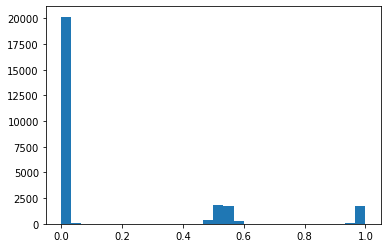

In [ ]:
plt.hist(val_preds[~is_spam_index_], bins=30)
plt.show()

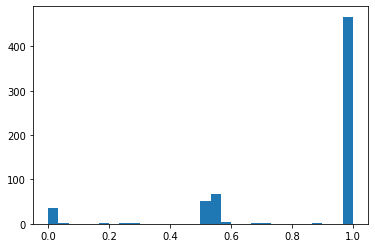

In [ ]:
plt.hist(val_preds[is_spam_index_], bins=30)
plt.show()

In [ ]:
# Pred Value Counts ------------------------------------------------------------
print("Value Counts (0: ham, 1: spam):")
print("-- Validation:")
print(pd.Series(np.where(val_preds>0.5, 1, 0)).value_counts())
print("-- Test:")
print(pd.Series(np.where(preds_mean>0.5, 1, 0)).value_counts().sort_index())
print()

# Threshold --------------------------------------------------------------------
# threshold for pseudo labeling.
#  * pseudo ham < threshold
#  * threshold <= unkown <= 1-threshold
#  * 1 - threshold < pseudo spam

threshold = 0.01

is_spam_conf = preds_mean > (1-threshold)
is_not_spam_conf = preds_mean < threshold
is_unkown = ~(is_spam_conf | is_not_spam_conf)

print("# of high confidence spam:", is_spam_conf.sum())
print("# of high confidence ham:", is_not_spam_conf.sum())
print("Unkown:", is_unkown.sum(), "/", len(preds_mean), f"({is_unkown.sum() / len(preds_mean) * 100 :.2f} %)")

Value Counts (0: ham, 1: spam):
-- Validation:
0    20110
1     7035
dtype: int64
-- Test:
0    30620
1    10214
dtype: int64

# of high confidence spam: 2249
# of high confidence ham: 27718
Unkown: 10867 / 40834 (26.61 %)


In [ ]:
pseudo_df = test_df.copy()
pseudo_df["judgement"] = 0
pseudo_df.loc[is_spam_conf, "judgement"] = 1
pseudo_df = pseudo_df.loc[is_spam_conf|is_not_spam_conf].reset_index(drop=True)

In [ ]:
pseudo_df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
sub = pd.DataFrame(test_df["id"])
sub["judgement"] = pd.Series(np.where(preds_mean>0.5, 1, 0))
sub["judgement"].value_counts()

0    30620
1    10214
Name: judgement, dtype: int64

In [ ]:
#sub.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(pseud_df,step1).csv', header=None, index=None)
#sub.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(pseud_df,step1+stopword).csv', header=None, index=None)
#sub.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(pseud_df,step1+stopword+c).csv', header=None, index=None)
#sub.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(pseud_df,step1+stopword+c+ngram).csv', header=None, index=None)
sub.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(pseud_df,step1+best_param).csv', header=None, index=None)

In [ ]:
pseudo_train_df = pd.concat([train_df, pseudo_df], axis=0)

In [ ]:
X = pd.DataFrame(pseudo_train_df['clean_abstract'])
y = pd.DataFrame(pseudo_train_df['judgement'])

In [ ]:

y["judgement"].value_counts()

0.0    54891
1.0     2777
Name: judgement, dtype: int64

In [ ]:
# Parameter --------------------------------------------------------------------
n_splits = 5

# tokenizer 
tokenizer_name = None
tokenizer_params = {}

# vectorizer
vectorizer_name = "CountVectorizer"
vectorizer_params = {
    "min_df": 2, "ngram_range": (1, 2),
    "stop_words": "english"}

# model
model_name = "MultinomialNB"
model_params = {}
model_fit_params = {}

In [ ]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
train_preds = []
preds = []
oof_pred = np.zeros(len(X))
preprocessor = Preprocessor()

# for i in range(5):
for train_index, val_index in kf.split(X):
  # print(train_index, val_index)

  # # アンダーサンプリングしながら訓練用データの作成
  # sampler = RandomUnderSampler(random_state=SEED+i)
  # X_resampled, y_resampled = sampler.fit_resample(X,y)

  # # 検証用データの作成（random_stateを変えて取得）
  # sampler = RandomUnderSampler(random_state=SEED+i+10)
  # X_val, y_val = sampler.fit_resample(X,y)
  X_resampled, y_resampled = X["clean_abstract"].values[train_index], y["judgement"].values[train_index]
  X_val, y_val = X["clean_abstract"].values[val_index], y["judgement"].values[val_index]

  # preprocess
  X_resampled = preprocessor.preprocess(X_resampled)
  X_val = preprocessor.preprocess(X_val)

  # tokenizer
  if tokenizer_name:
    tokenizer = tokenizer_cls_dict[tokenizer_name](**tokenizer_params)
    tokenizer.fit(X_resampled)
  else:
    tokenizer = None

  # vectorizer
  vectorizer = vectorizer_cls_dict[vectorizer_name](tokenizer=tokenizer, **vectorizer_params)
  vectorizer.fit(X_resampled.astype('U'))

  # 単語の出現回数取得
  # 単語の種類の表示
  print('word size: ', len(vectorizer.vocabulary_))
  # 先頭５件の単語を表示
  print('word content: ', dict(list(vectorizer.vocabulary_.items())[0:5]))

  # 訓練データと検証データをベクトル化
  X_resampled_vec = vectorizer.transform(X_resampled.astype('U'))
  X_val_vec = vectorizer.transform(X_val.astype('U'))

  # ベルヌーイモデルで学習
  model = model_cls_dict[model_name](**model_params)
  model.fit(X_resampled_vec, y_resampled, **model_fit_params)

  val_pred = model.predict(X_val_vec)
  oof_pred[val_index] = val_pred

  # F1スコアのprint
  print("val_fbeta-score",fbeta_score(val_pred, y_val,beta=7))
  print("------------------------------------------------------------------------------------------------------------------")

  # for train ------------------------------------------------------------------
  input_vec = vectorizer.transform(preprocessor.preprocess(train_df['clean_abstract'].values.astype('U')))
  train_preds.append(model.predict_proba(input_vec))

  # for test -------------------------------------------------------------------
  # testデータをベクトル化
  # df_data = pd.DataFrame(test, columns=['contents'])
  input_vec = vectorizer.transform(preprocessor.preprocess(test_df['clean_abstract'].values.astype('U')))

  # testの予測→seed毎に空のリストに格納
  pred = model.predict_proba(input_vec)
  preds.append(pred)

print("val_fbeta-oof score",fbeta_score(oof_pred, y["judgement"].values,beta=7))
print()

# トレーニングデータを使ったバリデーション =====================================
train_preds = np.array(train_preds)[:, :, 1]
train_preds_mean = train_preds.mean(axis=0)
train_pred = np.where(train_preds_mean > 0.5, 1, 0)
train_true = train_df["judgement"].values



word size:  579921
word content:  {'longitudinal': 303089, 'studies': 505858, 'indicate': 262856, 'declines': 136696, 'cognition': 93838}
val_fbeta-score 0.7095144152562904
------------------------------------------------------------------------------------------------------------------
word size:  579882
word content:  {'objective': 355122, 'report': 447388, 'case': 72589, 'series': 477266, 'basal': 54312}
val_fbeta-score 0.699149727647137
------------------------------------------------------------------------------------------------------------------
word size:  579022
word content:  {'longitudinal': 302211, 'studies': 504908, 'indicate': 262072, 'declines': 136209, 'cognition': 93494}
val_fbeta-score 0.7033729185068864
------------------------------------------------------------------------------------------------------------------
word size:  580409
word content:  {'longitudinal': 303186, 'studies': 506155, 'indicate': 262959, 'declines': 136698, 'cognition': 93788}
val_fbeta-scor

In [ ]:
# To Numpy Array ---------------------------------------------------------------
preds = np.array(preds)
preds = preds[:, :, 1]

preds_mean = preds.mean(axis=0)

# Pred Value Counts ------------------------------------------------------------
print("Value Counts (0: ham, 1: spam):")
print("-- single pred:")
print(pd.Series(np.where(pred[:, 1]>0.5, 1, 0)).value_counts().sort_index())
print("-- mean pred:")
print(pd.Series(np.where(preds_mean>0.5, 1, 0)).value_counts().sort_index())
print()

Value Counts (0: ham, 1: spam):
-- single pred:
0    38611
1     2223
dtype: int64
-- mean pred:
0    38541
1     2293
dtype: int64



In [ ]:
threshold = 0.01

is_spam_conf = preds_mean > (1-threshold)
is_not_spam_conf = preds_mean < threshold
is_unkown = ~(is_spam_conf | is_not_spam_conf)

print("# of high confidence spam:", is_spam_conf.sum())
print("# of high confidence ham:", is_not_spam_conf.sum())
print("Unkown:", is_unkown.sum(), "/", len(preds_mean), f"({is_unkown.sum() / len(preds_mean) * 100 :.2f} %)")

# of high confidence spam: 1729
# of high confidence ham: 31829
Unkown: 7276 / 40834 (17.82 %)


In [ ]:
# pseudo_df = test_df.loc[is_spam_conf|is_not_spam_conf].copy().reset_index(drop=True)
pseudo_df = test_df.copy()
pseudo_df["judgement"] = 0
pseudo_df.loc[is_spam_conf, "judgement"] = 1
pseudo_df = pseudo_df.loc[is_spam_conf|is_not_spam_conf].reset_index(drop=True)

In [ ]:
pseudo_df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
pseudo_df

,id,title,abstract,judgement,clean_title,clean_abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...,0,estimating potential effects covid pandemic ...,objective paper analyse changes food com...
1,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...,0,15o water pet intraoperative brain mapping c...,15o water pet performed patients structural...
2,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...,0,adaptive image segmentation robust measuremen...,present method significantly improves magne...
3,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...,0,comparison epidemiological variations covid ...,objective study compare epidemiological ...
4,27150,Anthraquinone Derivatives as an Immune Booster...,Anthraquinone derivatives are identified for t...,0,anthraquinone derivatives immune booster t...,anthraquinone derivatives identified immune...
...,...,...,...,...,...,...
33553,67973,Psychosocial Burdens of a Renal Transplant Rec...,The impact of COVID-19 on transplant recipient...,0,psychosocial burdens renal transplant recipi...,impact covid transplant recipients yet f...
33554,67974,"Knowledge, Attitude, and Practices of Healthca...",In the current outbreak of novel coronavirus (...,0,knowledge attitude practices healthcare prof...,current outbreak novel coronavirus covid he...
33555,67975,Safety and Efficacy of Anti-Il6-Receptor Tocil...,BACKGROUND: As the novel SARS-CoV-2 pandemic o...,0,safety efficacy anti il6 receptor tocilizuma...,background novel sars cov pandemic occurred ...
33556,67976,Functional imaging of head and neck tumors usi...,Positron emission tomography (PET) is an imagi...,0,functional imaging head neck tumors using po...,positron emission tomography pet imaging mod...


In [ ]:
#sub = pd.DataFrame(test_df["id"])
#sub["judgement"] = pd.Series(np.where(preds_mean>0.5, 1, 0))

In [ ]:
#sub["judgement"].value_counts()

0    38541
1     2293
Name: judgement, dtype: int64

In [ ]:
#sub.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(pseud_df,step2).csv', header=None, index=None)

In [ ]:
pseudo_train_df = pd.concat([train_df, pseudo_df], axis=0)

In [ ]:
X = pd.DataFrame(pseudo_train_df['clean_abstract'])
y = pd.DataFrame(pseudo_train_df['judgement'])

In [ ]:

y["judgement"].value_counts()

0.0    58342
1.0     2361
Name: judgement, dtype: int64

In [ ]:
# Parameter --------------------------------------------------------------------
n_splits = 5

# tokenizer 
tokenizer_name = None
tokenizer_params = {}

# vectorizer
vectorizer_name = "CountVectorizer"
vectorizer_params = {
    "min_df": 2, "ngram_range": (1, 2),
    "stop_words": "english"}

# model
model_name = "MultinomialNB"
model_params = {}
model_fit_params = {}

In [ ]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
train_preds = []
preds = []
oof_pred = np.zeros(len(X))
preprocessor = Preprocessor()

# for i in range(5):
for train_index, val_index in kf.split(X):
  # print(train_index, val_index)

  # # アンダーサンプリングしながら訓練用データの作成
  # sampler = RandomUnderSampler(random_state=SEED+i)
  # X_resampled, y_resampled = sampler.fit_resample(X,y)

  # # 検証用データの作成（random_stateを変えて取得）
  # sampler = RandomUnderSampler(random_state=SEED+i+10)
  # X_val, y_val = sampler.fit_resample(X,y)
  X_resampled, y_resampled = X["clean_abstract"].values[train_index], y["judgement"].values[train_index]
  X_val, y_val = X["clean_abstract"].values[val_index], y["judgement"].values[val_index]

  # preprocess
  X_resampled = preprocessor.preprocess(X_resampled)
  X_val = preprocessor.preprocess(X_val)

  # tokenizer
  if tokenizer_name:
    tokenizer = tokenizer_cls_dict[tokenizer_name](**tokenizer_params)
    tokenizer.fit(X_resampled.astype('U'))
  else:
    tokenizer = None

  # vectorizer
  vectorizer = vectorizer_cls_dict[vectorizer_name](tokenizer=tokenizer, **vectorizer_params)
  vectorizer.fit(X_resampled.astype('U'))

  # 単語の出現回数取得
  # 単語の種類の表示
  print('word size: ', len(vectorizer.vocabulary_))
  # 先頭５件の単語を表示
  print('word content: ', dict(list(vectorizer.vocabulary_.items())[0:5]))

  # 訓練データと検証データをベクトル化
  X_resampled_vec = vectorizer.transform(X_resampled.astype('U'))
  X_val_vec = vectorizer.transform(X_val.astype('U'))

  # ベルヌーイモデルで学習
  model = model_cls_dict[model_name](**model_params)
  model.fit(X_resampled_vec, y_resampled, **model_fit_params)

  val_pred = model.predict(X_val_vec)
  oof_pred[val_index] = val_pred

  # F1スコアのprint
  print("val_fbeta-score",fbeta_score(val_pred, y_val,beta=7))
  print("------------------------------------------------------------------------------------------------------------------")

  # for train ------------------------------------------------------------------
  input_vec = vectorizer.transform(preprocessor.preprocess(train_df['clean_abstract'].values.astype('U')))
  train_preds.append(model.predict_proba(input_vec))

  # for test -------------------------------------------------------------------
  # testデータをベクトル化
  # df_data = pd.DataFrame(test, columns=['contents'])
  input_vec = vectorizer.transform(preprocessor.preprocess(test_df['clean_abstract'].values.astype('U')))

  # testの予測→seed毎に空のリストに格納
  pred = model.predict_proba(input_vec)
  preds.append(pred)




word size:  605261
word content:  {'longitudinal': 315870, 'studies': 527637, 'indicate': 273772, 'declines': 142418, 'cognition': 97329}
val_fbeta-score 0.7711038961038963
------------------------------------------------------------------------------------------------------------------
word size:  605690
word content:  {'objective': 370749, 'report': 467060, 'case': 75465, 'series': 498383, 'basal': 56496}
val_fbeta-score 0.7204674252075737
------------------------------------------------------------------------------------------------------------------
word size:  606468
word content:  {'longitudinal': 316238, 'studies': 528408, 'indicate': 274364, 'declines': 142412, 'cognition': 97434}
val_fbeta-score 0.7405515832482124
------------------------------------------------------------------------------------------------------------------
word size:  605834
word content:  {'longitudinal': 316516, 'studies': 528059, 'indicate': 274591, 'declines': 142739, 'cognition': 97556}
val_fbeta-sco

TypeError: ignored

In [ ]:
print("val_fbeta-oof score",fbeta_score(oof_pred, y["judgement"].values,beta=7))
print()

# トレーニングデータを使ったバリデーション =====================================
train_preds = np.array(train_preds)[:, :, 1]
train_preds_mean = train_preds.mean(axis=0)
train_pred = np.where(train_preds_mean > 0.5, 1, 0)
train_true = train_df["judgement"].values

# To Numpy Array ---------------------------------------------------------------
preds = np.array(preds)
preds = preds[:, :, 1]

preds_mean = preds.mean(axis=0)

# Pred Value Counts ------------------------------------------------------------
print("Value Counts (0: ham, 1: spam):")
print("-- single pred:")
print(pd.Series(np.where(pred[:, 1]>0.5, 1, 0)).value_counts().sort_index())
print("-- mean pred:")
print(pd.Series(np.where(preds_mean>0.5, 1, 0)).value_counts().sort_index())
print()

val_fbeta-oof score 0.7376185458377239

Value Counts (0: ham, 1: spam):
-- single pred:
0    39158
1     1676
dtype: int64
-- mean pred:
0    39090
1     1744
dtype: int64



In [ ]:
sub = pd.DataFrame(test_df["id"])
sub["judgement"] = pd.Series(np.where(preds_mean>0.5, 1, 0))

In [ ]:

sub["judgement"].value_counts()

0    39090
1     1744
Name: judgement, dtype: int64

In [ ]:
sub

,id,judgement
0,27145,0
1,27146,0
2,27147,0
3,27148,0
4,27149,0
...,...,...
40829,67974,0
40830,67975,0
40831,67976,0
40832,67977,0


In [ ]:
sub.to_csv('/content/drive/MyDrive/機械学習/Competitions/Signate/医学論文の自動仕分けチャレンジ/output/sample_submit(pseud_df,step3).csv', header=None, index=None)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2, random_state=SEED)

In [ ]:
def objective(trial):
    vectorizer_params = {
        "min_df": trial.suggest_discrete_uniform(name="min_df",low=0,high=10,q=1),  # 2
        "max_df": trial.suggest_discrete_uniform(name="max_df",low=0,high=1.0,q=0.01),  # 0.7
        "ngram_range": (1, 2),  # (1, 1),
        "stop_words": ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on'], #None,
        "token_pattern": None}
    vectorizer = CountVectorizer(vectorizer_params)
    
    train_term_doc = vectorizer.fit_transform(X_train['clean_abstract'].astype('U'))
    valid_term_doc = vectorizer.transform(X_val['clean_abstract'].astype('U'))

    
    model = MultinomialNB()
    model.fit(train_term_doc, y_train)
    preds = model.predict(valid_term_doc)
    
    fbeta = fbeta_score(y_val,preds,beta=7)
    return fbeta

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=SEED))
study.optimize(objective, n_trials=50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2021-09-10 04:12:42,984] Trial 22 finished with value: 0.404753703065794 and parameters: {'min_df': 2.0, 'max_df': 0.66}. Best is trial 0 with value: 0.404753703065794.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2021-09-10 04:12:45,791] Trial 23 finished with value: 0.404753703065794 and parameters: {'min_df': 3.0, 'max_df': 0.52}. Best is trial 0 with value: 0.404753703065794.


KeyboardInterrupt: ignored

In [ ]:
print(f"Best Value: {study.best_trial.value}")
print(f"Best Params: {study.best_params}")

Best Value: 0.404753703065794
Best Params: {'min_df': 3.74, 'max_df': 0.96}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([('vectorizer', CountVectorizer()), ('multinomial_nb', MultinomialNB())])
params = {
    'vectorizer__max_df': [1.0, 0.99,0.9,0.8,0.7,0.6],
    'vectorizer__ngram_range': [(1,1), (1, 2)],
    'vectorizer__stop_words' : [['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']]
}
clf = GridSearchCV(pipeline, params)

clf.fit(X_train['clean_abstract'].astype('U'),y_train)
preds = clf.predict(X_val['clean_abstract'].astype('U'))
fbeta = fbeta_score(y_val,preds,beta=7)
print(fbeta)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConv

AttributeError: ignored

In [ ]:
preds = clf.predict(X_val['clean_abstract'].astype('U'))
fbeta = fbeta_score(y_val,preds,beta=7)
best = clf.best_estimator_
print(best)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['i', 'a', 'an', 'the', 'to', 'and',
                                             'or', 'if', 'is', 'are', 'am',
                                             'it', 'this', 'that', 'of', 'from',
                                             'in', 'on'],
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('multinomial_nb',
               

In [ ]:
def objective(trial):
    vectorizer_params = {
        "min_df": trial.suggest_discrete_uniform(name="min_df",low=0,high=10,q=1),  # 2
        "max_df": trial.suggest_discrete_uniform(name="max_df",low=0,high=1.0,q=0.01),  # 0.7
        "ngram_range": (1, 2),  # (1, 1),
        "stop_words": ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on'], #None,
        "token_pattern": None}

    model_params = {
        
    }
    vectorizer = CountVectorizer(vectorizer_params)
    
    train_term_doc = vectorizer.fit_transform(X_train['clean_abstract'].astype('U'))
    valid_term_doc = vectorizer.transform(X_val['clean_abstract'].astype('U'))

    
    model = MultinomialNB()
    model.fit(train_term_doc, y_train)
    preds = model.predict(valid_term_doc)
    
    fbeta = fbeta_score(y_val,preds,beta=7)
    return fbeta